In [2]:
from __future__ import division
import pickle
import os
import types
import random
import uuid
import math
from copy import deepcopy as copy

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import numpy as np
import tensorflow as tf
from scipy.misc import logsumexp

In [3]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)
# mpl.rc('text', usetex=True)

In [5]:
data_dir = os.path.join('data', '3.0')

In [6]:
sess = tf.Session()

create envs, pilot policies

In [7]:
n_train_tasks = 49
n_act_dim = 4
n_obs_dim = 4
gamma = 0.99
max_ep_len = 200
accel = 0.01
goal_dist_thresh = 2*accel
succ_rew_bonus = 1
crash_rew_penalty = -1
max_speed = 10*accel

In [8]:
is_succ = lambda r: r[-1][2] > succ_rew_bonus / 2
is_crash = lambda r: r[-1][2] < crash_rew_penalty / 2

In [9]:
train_goals = np.random.random((n_train_tasks, 2))

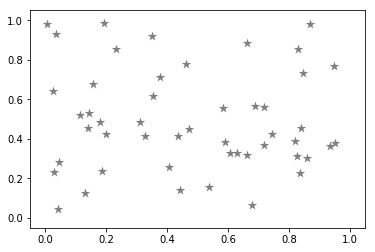

In [10]:
plt.scatter(train_goals[:, 0], train_goals[:, 1], linewidth=0, color='gray', s=100, marker='*')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

In [11]:
# with open(os.path.join(data_dir, 'train_goals.pkl'), 'wb') as f:
#   pickle.dump(train_goals, f, pickle.HIGHEST_PROTOCOL)

In [12]:
with open(os.path.join(data_dir, 'train_goals.pkl'), 'rb') as f:
  train_goals = pickle.load(f)

In [13]:
def make_reward_func(goal):

  def reward_shaping(obs):
    return -np.linalg.norm((obs[:2] - goal))

  def reward_func(prev_obs, action, obs):
    pos = obs[:2]
    if (pos < 0).any() or (pos >= 1).any():
      r = crash_rew_penalty
    elif (np.abs(pos - goal) <= goal_dist_thresh).all():
      r = succ_rew_bonus
    else:
      r = gamma * reward_shaping(obs) - reward_shaping(prev_obs)
    return r
  
  return reward_func

In [14]:
class PointMassNav(gym.Env):
  metadata = {
    'render.modes': ['human']
  }
  
  def __init__(
      self, 
      using_inertia=True,
      max_ep_len=max_ep_len, 
      reward_func=None,
      goal=None,
      rand_goal=False,
      expose_goal=False
    ):
    
    self.expose_goal = expose_goal
    if self.expose_goal:
      lows = np.ones(n_obs_dim + 2) * -1
      highs = np.ones(n_obs_dim + 2) * 2
    else:
      lows = np.ones(n_obs_dim) * -1
      highs = np.ones(n_obs_dim) * 2
      
    self.observation_space = spaces.Box(lows, highs, dtype=np.float32)
    self.action_space = spaces.Discrete(n_act_dim)
    
    self.pos = None
    self.vel = None
    self.curr_step = None
    self.viewer = None
    self.curr_obs = None
    
    self.succ_rew_bonus = succ_rew_bonus
    self.max_ep_len = max_ep_len
    self.reward_func = reward_func
    self.using_inertia = using_inertia
    self.goal = goal
    self.rand_goal = rand_goal
    
  def copy(self):
    new_env = PointMassNav(using_inertia=self.using_inertia,
                       max_ep_len=self.max_ep_len,
                       reward_func=self.reward_func,
                       goal=self.goal,
                       rand_goal=self.rand_goal,
                       expose_goal=self.expose_goal)
    new_env.pos = copy(self.pos)
    new_env.vel = copy(self.vel)
    new_env.curr_step = copy(self.curr_step)
    new_env.curr_obs = copy(self.curr_obs)
    return new_env
    
  def _obs_of_pos_vel(self, pos, vel):
    if self.expose_goal:
      return np.concatenate((pos, vel, self.goal))
    else:
      return np.concatenate((pos, vel))
    
  def obs(self):
    self.curr_obs = self._obs_of_pos_vel(self.pos, self.vel)
    return self.curr_obs

      
  
  def _next_pos_vel(self, pos, vel, action):
    next_pos = copy(pos)
    if self.using_inertia:
      next_vel = copy(vel)
    else:
      next_vel = np.zeros(2)
      
    if action == 0: # left
      next_vel[1] -= accel
    elif action == 1: # right
      next_vel[1] += accel
    elif action == 2: # up
      next_vel[0] -= accel
    elif action == 3: # down
      next_vel[0] += accel
    else:
      raise ValueError('invalid action')
      
    next_vel = np.maximum(np.minimum(next_vel, max_speed), -max_speed)
    next_pos += next_vel
    
    return next_pos, next_vel



  def step(self, action):  
    self.pos, self.vel = self._next_pos_vel(self.pos, self.vel, action)
        
    self.curr_step += 1
    succ = (np.abs(self.pos - self.goal) <= goal_dist_thresh).all()
    oob = (self.pos < 0).any() or (self.pos >= 1).any()
    oot = self.curr_step >= self.max_ep_len
    
    obs = self.obs()
    r = self.reward_func(self.prev_obs, action, obs)
    done = oot or succ or oob
    info = {}
      
    self.prev_obs = obs
    
    return obs, r, done, info
    
  def reset(self):
    self.pos = np.random.random(2)
    self.vel = np.zeros(2)
    
    if self.rand_goal:
      self.goal = np.random.random(2)
      self.reward_func = make_reward_func(self.goal)
    self.curr_step = 0
    self.prev_obs = self.obs()
    return self.prev_obs
  
  def render(self, mode='human', close=False):
    if close:
      if self.viewer is not None:
        self.viewer.close()
        self.viewer = None
      return
    
    if self.viewer is None:
      self.viewer = rendering.SimpleImageViewer()
    
    fig = plt.figure()
    canvas = FigureCanvas(fig)
    
    plt.scatter([self.goal[0]], [self.goal[1]], color='gray', linewidth=0, alpha=0.75, marker='*')
    plt.scatter([self.pos[0]], [self.pos[1]], color='orange', linewidth=0, alpha=0.75)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.axis('off')
    
    agg = canvas.switch_backends(FigureCanvas)
    agg.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    self.viewer.imshow(np.fromstring(agg.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3))
    plt.close()

In [15]:
train_reward_funcs = [make_reward_func(goal) for goal in train_goals]
train_newton_envs = [PointMassNav(reward_func=r, goal=train_goals[i], using_inertia=True) for i, r in enumerate(train_reward_funcs)]
train_aristotle_envs = [PointMassNav(reward_func=r, goal=train_goals[i], using_inertia=False) for i, r in enumerate(train_reward_funcs)]

In [16]:
def run_ep(policy, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = policy(obs)
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

In [17]:
def make_aristotle_pilot_policy(goal, denoise=False):
  eps = accel if denoise else 0
  gx, gy = goal
  def aristotle_pilot_policy(obs):
    x, y = obs[:2]
    up = gx<x-eps
    down = gx>x+eps
    left = gy<y-eps
    right = gy>y+eps
    lr = left or right
    ud = up or down
    if lr and (not ud or np.random.random() < 0.5):
      if left:
        return 0
      elif right:
        return 1
    elif ud:
      if up:
        return 2
      elif down:
        return 3
    return 0
  return aristotle_pilot_policy

In [18]:
def make_newton_pilot_policy(env, beta=10, vel_penalty=0.2):
  gx, gy = env.goal
  nA = 4
    
  def next_vel(vel, action):
    next_vel = copy(vel)  
    if action == 0: # left
      next_vel[1] -= accel
    elif action == 1: # right
      next_vel[1] += accel
    elif action == 2: # up
      next_vel[0] -= accel
    elif action == 3: # down
      next_vel[0] += accel
    else:
      raise ValueError('invalid action')
      
    next_vel = np.maximum(np.minimum(next_vel, max_speed), -max_speed)
    
    return next_vel

  def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))
  
  def newton_pilot_policy(obs):
    x, y, dx, dy = obs
    vel = np.array([dx,dy])
    x_diff = gx-x
    y_diff = gy-y
    true_vec = np.array([x_diff,y_diff])
    vel_vecs = np.array([next_vel(vel,a) for a in range(nA)])
    angle_diffs = np.dot(true_vec + vel_vecs, true_vec)
    action_weights = (angle_diffs - vel_penalty * np.linalg.norm(vel_vecs, axis=1))
    return np.random.choice(np.asarray(range(nA)),p=softmax(beta * action_weights))

  return newton_pilot_policy

In [19]:
aristotle_pilot_policies = [make_aristotle_pilot_policy(goal,denoise=True) for goal in train_goals]

In [20]:
newton_pilot_policies = [make_newton_pilot_policy(env, 1000) for env in train_newton_envs]

sanity-check envs, agents

In [21]:
train_task_idx = 0

In [22]:
# run_ep(aristotle_pilot_policies[train_task_idx], train_aristotle_envs[train_task_idx], render=True)

In [23]:
# train_aristotle_envs[train_task_idx].close()

In [24]:
# run_ep(newton_pilot_policies[train_task_idx], train_newton_envs[train_task_idx], render=True)

In [25]:
# train_newton_envs[train_task_idx].close()

fit internal dynamics model

In [26]:
n_train_rollouts_per_env = 1000

In [27]:
# demo_rollouts = [[run_ep(newton_pilot_policies[train_task_idx], newton_env, render=False, task_idx=train_task_idx)
#                   for _ in range(n_train_rollouts_per_env)]
#                  for train_task_idx, newton_env in enumerate(train_newton_envs)]

In [28]:
# with open(os.path.join(data_dir, 'newton_pilot_policy_demo_rollouts.pkl'), 'wb') as f:
#   pickle.dump(demo_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [29]:
with open(os.path.join(data_dir, 'newton_pilot_policy_demo_rollouts.pkl'), 'rb') as f:
  demo_rollouts = pickle.load(f)

In [30]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
  ):
  out = input_placeholder
  with tf.variable_scope(scope, reuse=reuse):
    for _ in range(n_layers):
      out = tf.layers.dense(out, size, activation=activation)
    out = tf.layers.dense(out, output_size, activation=output_activation)
  return out

In [31]:
def onehot_encode(i, n):
  x = np.zeros(n)
  x[i] = 1
  return x

def onehot_decode(x):
  l = np.nonzero(x)[0]
  assert len(l) == 1
  return l[0]

n_obs_feats = n_obs_dim
def featurize_obs(s):
  return s

n_act_feats = 2
feats_of_act = np.array([
  [0, -1],
  [0, 1],
  [-1, 0],
  [1, 0]
], dtype=float) * accel
def featurize_act(a):
  return feats_of_act[a, :]

In [32]:
def vectorize_rollouts(rollouts):
  obs = [[] for _ in range(n_train_tasks)]
  actions = [[] for _ in range(n_train_tasks)]
  next_obs = [[] for _ in range(n_train_tasks)]
  for task_idx, task_rollouts in enumerate(rollouts):
    for task_rollout in task_rollouts:
      more_obs, more_actions, _, more_next_obs = list(zip(*task_rollout))[:4]
      obs[task_idx].extend([featurize_obs(s) for s in more_obs])
      actions[task_idx].extend(more_actions)
      next_obs[task_idx].extend([featurize_obs(s) for s in more_next_obs])
  l = min(len(x) for x in obs)
  idxes = [random.sample(list(range(len(x))), l) for x in obs]
  f = lambda x: np.array(x[1])[idxes[x[0]]]
  obs = np.array(list(map(f, enumerate(obs))))
  actions = np.array(list(map(f, enumerate(actions))))
  action_feats = np.array([featurize_act(a) for a in actions])
  next_obs = np.array(list(map(f, enumerate(next_obs))))
  return obs, actions, action_feats, next_obs

In [33]:
demo_obs = None
demo_actions = None
demo_action_feats = None
demo_next_obs = None
demo_task_idxes = None
train_demo_example_idxes = None
val_demo_batch = None

In [34]:
def process_demo_rollouts(demo_rollouts):
  global demo_obs
  global demo_actions
  global demo_action_feats
  global demo_next_obs
  global demo_task_idxes
  global train_demo_example_idxes
  global val_demo_batch

  
  demo_obs, demo_actions, demo_action_feats, demo_next_obs = vectorize_rollouts(demo_rollouts)
  demo_example_idxes = list(range(demo_obs.shape[1]))
  
  random.shuffle(demo_example_idxes)
  n_train_demo_examples = int(0.9 * len(demo_example_idxes))
  train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
  val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
  val_demo_batch = (demo_obs[:, val_demo_example_idxes], demo_actions[:, val_demo_example_idxes],
        demo_action_feats[:, val_demo_example_idxes], demo_next_obs[:, val_demo_example_idxes])

In [35]:
process_demo_rollouts(demo_rollouts)

In [36]:
def sample_batch(size):
  idxes = random.sample(train_demo_example_idxes, size)
  demo_batch = (demo_obs[:, idxes], demo_actions[:, idxes], demo_action_feats[:,idxes], demo_next_obs[:, idxes])
  return demo_batch

In [37]:
gamma = 0.99
iterations = 100000
learning_rate = 1e-3
batch_size = 512 // n_train_tasks
sq_td_err_penalty = 1e0
trans_err_penalty = 1e4

q_n_layers = 1
q_layer_size = 32
q_activation = tf.nn.relu
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 32
invdyn_activation = tf.nn.relu
invdyn_output_activation = None

constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 500

val_update_freq = 100
n_val_eval_rollouts = 100

In [38]:
im_scope = str(uuid.uuid4())
q_scope = str(uuid.uuid4())
invdyn_scope = str(uuid.uuid4())

In [39]:
demo_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
demo_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None])
demo_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats])
demo_next_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
demo_batch_size_ph = tf.placeholder(tf.int32)

constraint_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
constraint_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None])
constraint_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats])
constraint_batch_size_ph = tf.placeholder(tf.int32)

In [40]:
demo_batch_idxes = tf.reshape(
  tf.range(0, demo_batch_size_ph, 1), 
  [demo_batch_size_ph, 1])

extract_task = lambda x, i: tf.squeeze(tf.gather(x, tf.convert_to_tensor(
  [i], dtype=tf.int32)), axis=[0]) 

demo_q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation
  ), 
  tf.concat([
    demo_batch_idxes, 
    tf.expand_dims(extract_task(demo_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

demo_v_t = tf.reduce_logsumexp(
  tf.stack([build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True
  ) for train_task_idx in range(n_train_tasks)], axis=0),
  axis=2)

act_log_likelihoods = demo_q_t - demo_v_t

In [41]:
neg_avg_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [42]:
pred_next_obs = build_mlp(
  tf.concat((demo_obs_t_ph, demo_act_t_feats_ph), axis=2),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

In [43]:
constraint_act_t_feats_reshaped = tf.reshape(
  constraint_act_t_feats_ph, [n_train_tasks*constraint_batch_size_ph, n_act_feats])

constraint_obs_t_reshaped = tf.reshape(
  constraint_obs_t_ph, [n_train_tasks*constraint_batch_size_ph, n_obs_feats])

demo_act_t_feats_reshaped = tf.reshape(
  demo_act_t_feats_ph, [n_train_tasks*demo_batch_size_ph, n_act_feats])

demo_obs_t_reshaped = tf.reshape(
  demo_obs_t_ph, [n_train_tasks*demo_batch_size_ph, n_obs_feats])

demo_next_obs_t_reshaped = tf.reshape(
  demo_next_obs_t_ph, [n_train_tasks, demo_batch_size_ph, n_obs_feats])

demo_pred_next_obs_t_reshaped = tf.reshape(
    pred_next_obs, [n_train_tasks, demo_batch_size_ph, n_obs_feats])

In [44]:
assert n_obs_feats == 4
assert n_act_feats == 2

In [45]:
trans_err = demo_pred_next_obs_t_reshaped - demo_next_obs_t_reshaped

In [46]:
sq_trans_err = tf.reduce_mean(trans_err**2)

In [47]:
# Predicted constraint next state given inv dyns
constraint_obs_tp1 = tf.reshape(build_mlp(
  tf.concat((constraint_obs_t_ph, constraint_act_t_feats_ph), axis=2),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True), [n_train_tasks, constraint_batch_size_ph, n_obs_feats])

In [48]:
# Predicted next state q-vals
q_tp1 = tf.stack([build_mlp(
  extract_task(constraint_obs_tp1, train_task_idx),
  n_act_dim, q_scope+'-'+str(train_task_idx), 
  n_layers=q_n_layers, size=q_layer_size,
  activation=q_activation, output_activation=q_output_activation, 
  reuse=True) for train_task_idx in range(n_train_tasks)], axis=0)
v_tp1 = tf.reduce_logsumexp(q_tp1, axis=2)

In [49]:
# Predicted next state rewards
rew_ts = []
for train_task_idx in range(n_train_tasks):
  goal_x = tf.convert_to_tensor(train_goals[train_task_idx, 0], dtype=tf.float32)
  goal_y = tf.convert_to_tensor(train_goals[train_task_idx, 1], dtype=tf.float32)
  
  constraint_obs_tp1_of_task = extract_task(constraint_obs_tp1, train_task_idx)
  constraint_obs_t_of_task = extract_task(constraint_obs_t_ph, train_task_idx)

  pos_x_tp1 = tf.gather(constraint_obs_tp1_of_task, tf.convert_to_tensor(
    [0], dtype=tf.int32), axis=1)
  
  pos_y_tp1 = tf.gather(constraint_obs_tp1_of_task, tf.convert_to_tensor(
    [1], dtype=tf.int32), axis=1)
  
  pos_x_t = tf.gather(constraint_obs_t_of_task, tf.convert_to_tensor(
    [0], dtype=tf.int32), axis=1)
  
  pos_y_t = tf.gather(constraint_obs_t_of_task, tf.convert_to_tensor(
    [1], dtype=tf.int32), axis=1)

  dist_to_goal_t = tf.sqrt((pos_x_t-goal_x)**2+(pos_y_t-goal_y)**2)
  dist_to_goal_tp1 = tf.sqrt((pos_x_tp1-goal_x)**2+(pos_y_tp1-goal_y)**2)

  crashed_t = tf.logical_or(tf.logical_or(tf.logical_or(
    pos_x_tp1 < 0, pos_y_tp1 < 0), pos_x_tp1 >= 1), pos_y_tp1 >= 1)
  succed_t = tf.logical_and(
    tf.abs(pos_x_tp1-goal_x) <= goal_dist_thresh, 
    tf.abs(pos_y_tp1-goal_y) <= goal_dist_thresh)

  rew_t = -gamma*dist_to_goal_tp1 + dist_to_goal_t
  rew_t += crash_rew_penalty * tf.cast(crashed_t, tf.float32)
  rew_t += succ_rew_bonus * tf.cast(tf.logical_and(tf.logical_not(crashed_t), succed_t), tf.float32)
  rew_t = tf.squeeze(rew_t)
  
  rew_ts.append(rew_t)
rew_t = tf.stack(rew_ts, axis=0)

In [50]:
# TD vals
target_t = rew_t + gamma * v_tp1

In [51]:
constraint_batch_idxes = tf.reshape(
  tf.range(0, constraint_batch_size_ph, 1), 
  [constraint_batch_size_ph, 1])

# Sampled constraint state q-vals
q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(constraint_obs_t_ph, train_task_idx), 
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation, 
    reuse=True
  ), 
  tf.concat([
    constraint_batch_idxes, 
    tf.expand_dims(extract_task(constraint_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

In [52]:
# Bellman errors
td_err = q_t - target_t

In [53]:
sq_td_err = tf.reduce_mean(td_err**2)

In [54]:
loss = neg_avg_log_likelihood + sq_td_err_penalty * sq_td_err + trans_err_penalty * sq_trans_err

In [55]:
trans_loss = sq_trans_err

In [56]:
full_update_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [57]:
trans_update_op = tf.train.AdamOptimizer(learning_rate).minimize(trans_loss)

In [58]:
def sample_constraints(_):
  constraint_rollouts = [[] for _ in range(n_train_tasks)]

  for train_task_idx in range(n_train_tasks):
    rollouts = [[] for _ in range(n_constraint_rollouts_per_env)]
    envs = [train_newton_envs[train_task_idx].copy() for _ in range(n_constraint_rollouts_per_env)]
    obses = np.array([env.reset() for env in envs])
    dones = [False for _ in envs]
    prev_obses = obses
    for step_idx in range(max_ep_len+1):
      not_done_idxes = [i for i, done in enumerate(dones) if not done]
      batch_size = len(not_done_idxes)
      if batch_size == 0:
        break
      actions = np.random.choice(n_act_dim, batch_size)
      for i, env_idx in enumerate(not_done_idxes):
        env = envs[env_idx]
        action = actions[i]
        obs, r, done, info = env.step(action)
        obses[env_idx] = obs
        dones[env_idx] = done
        rollouts[env_idx].append((prev_obses[env_idx], action))
      prev_obses = copy(obses)
    constraint_rollouts[train_task_idx].extend([r for r in rollouts if r != []])

  size = min(sum(len(r) for r in rollouts) for rollouts in constraint_rollouts)
  
  global train_constraint_example_idxes
  global val_constraint_batch
  global constraint_obs_t
  global constraint_act_t
  global constraint_act_t_feats
    
  constraint_obs_t = np.zeros((n_train_tasks, size, n_obs_feats))
  constraint_act_t = np.zeros((n_train_tasks, size))
  constraint_act_t_feats = np.zeros((n_train_tasks, size, n_act_feats))
  
  for train_task_idx in range(n_train_tasks):
    unfeat_obses, actions = list(zip(*sum(
      constraint_rollouts[train_task_idx], [])))
    obses = [featurize_obs(s) for s in unfeat_obses]
    act_feats = [featurize_act(a) for a in actions]
    idxes = random.sample(list(range(len(obses))), size)
    constraint_obs_t[train_task_idx, :, :] = np.array(obses)[idxes, :]
    constraint_act_t[train_task_idx, :] = np.array(actions)[idxes]
    constraint_act_t_feats[train_task_idx, :, :] = np.array(act_feats)[idxes, :]
  
  constraint_example_idxes = list(range(size))
  random.shuffle(constraint_example_idxes)
  n_train_constraint_examples = int(0.9 * size)
  
  train_constraint_example_idxes = constraint_example_idxes[:n_train_constraint_examples]
  val_constraint_example_idxes = constraint_example_idxes[n_train_constraint_examples:]
  val_constraint_batch = (constraint_obs_t[:, val_constraint_example_idxes],
                          constraint_act_t[:, val_constraint_example_idxes],
                          constraint_act_t_feats[:, val_constraint_example_idxes])

In [59]:
def sample_constraint_batch(size):
  global n_iters_since_prev_constraint_sample
  if n_iters_since_prev_constraint_sample % constraint_sampling_freq == 0:
    sample_constraints(size)
    n_iters_since_prev_constraint_sample = 0
  n_iters_since_prev_constraint_sample += 1

  idxes = random.sample(train_constraint_example_idxes, size)
  constraint_batch = (constraint_obs_t[:, idxes], 
                      constraint_act_t[:, idxes], 
                      constraint_act_t_feats[:, idxes])
  return constraint_batch

In [59]:
train_constraint_example_idxes = None
val_constraint_batch = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
n_iters_since_prev_constraint_sample = 0

In [60]:
tf.global_variables_initializer().run(session=sess)

In [61]:
n_iters = iterations * demo_obs.shape[1] // batch_size
full_train_logs = {
  'loss_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
  'int_dyn_err_evals': []
}

In [65]:
def compute_batch_loss(demo_batch, constraint_batch, trans_only=False, step=False, t=None):
  demo_batch_obs_t, demo_batch_act_t, demo_batch_act_t_feats, demo_batch_next_obs_t = demo_batch
  constraint_batch_obs_t, constraint_batch_act_t, constraint_batch_act_t_feats = constraint_batch
    
  feed_dict = {
    demo_obs_t_ph: demo_batch_obs_t,
    demo_act_t_ph: demo_batch_act_t,
    demo_act_t_feats_ph: demo_batch_act_t_feats,
    demo_next_obs_t_ph: demo_batch_next_obs_t,
    demo_batch_size_ph: demo_batch_obs_t.shape[1],
    constraint_obs_t_ph: constraint_batch_obs_t,
    constraint_act_t_ph: constraint_batch_act_t,
    constraint_act_t_feats_ph: constraint_batch_act_t_feats,
    constraint_batch_size_ph: constraint_batch_obs_t.shape[1],
  }
  
#   [loss_eval, neg_avg_log_likelihood_eval, sq_td_err_eval, sq_trans_err_eval] = sess.run(
#     [loss, neg_avg_log_likelihood, sq_td_err, sq_trans_err], feed_dict=feed_dict)
  if trans_only:
    [loss_eval] = sess.run([trans_loss], feed_dict=feed_dict)
    update_op = trans_update_op
    d = {
    'loss': loss_eval,
      }
  else:
    [loss_eval, trans_loss_eval, neg_avg_log_likelihood_eval, sq_td_err_eval] = sess.run(
        [loss, sq_trans_err, neg_avg_log_likelihood, sq_td_err], feed_dict=feed_dict)
    update_op = full_update_op
    d = {
        'loss': loss_eval,
        'tloss': trans_loss_eval,
        'nll': neg_avg_log_likelihood_eval,
        'ste': sq_td_err_eval
      }
  
  if step:
    sess.run(update_op, feed_dict=feed_dict)
  


  return d

In [63]:
val_log = None

1000 179680000 1.421204 1.331653 0.069744 1.407178 1.329100 0.059193
2000 179680000 1.373804 1.303411 0.058112 1.377831 1.300842 0.065074
3000 179680000 1.342097 1.257893 0.071767 1.338400 1.261377 0.064708
4000 179680000 1.264987 1.197500 0.054384 1.301750 1.225133 0.063027
5000 179680000 1.297226 1.218821 0.065238 1.273561 1.200602 0.060351
6000 179680000 1.223006 1.164489 0.046349 1.250796 1.182518 0.056171
7000 179680000 1.238502 1.170519 0.055839 1.231062 1.167447 0.051880
8000 179680000 1.186589 1.133079 0.042057 1.215450 1.154280 0.049753
9000 179680000 1.210176 1.141517 0.057570 1.204632 1.144068 0.049459


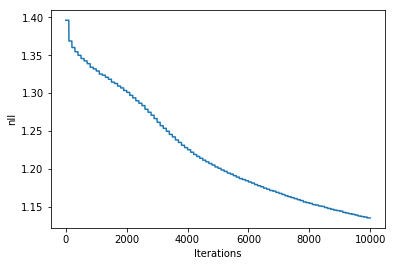

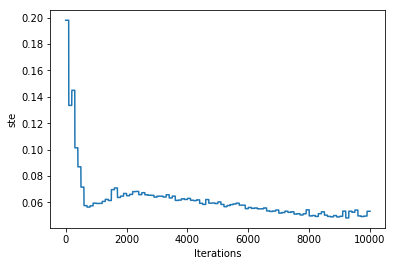

10000 179680000 1.185251 1.124728 0.049951 1.192589 1.134392 0.047396
11000 179680000 1.173320 1.111893 0.050621 1.184088 1.125484 0.047855
12000 179680000 1.147337 1.090162 0.046876 1.176754 1.118324 0.047849
13000 179680000 1.185261 1.125806 0.048671 1.171014 1.111317 0.049072
14000 179680000 1.184502 1.127216 0.046494 1.162460 1.105104 0.046795
15000 179680000 1.162792 1.108586 0.043735 1.159803 1.098732 0.050861
16000 179680000 1.152539 1.096431 0.045601 1.152241 1.093943 0.048063
17000 179680000 1.158500 1.105941 0.042587 1.146690 1.088955 0.047349
18000 179680000 1.117530 1.047185 0.059950 1.142361 1.083498 0.048420
19000 179680000 1.142934 1.082595 0.049621 1.138600 1.079862 0.048153


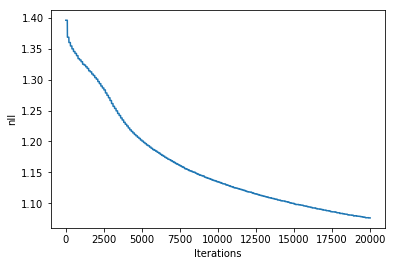

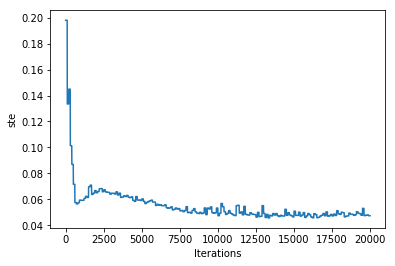

20000 179680000 1.140724 1.086421 0.043401 1.137351 1.075659 0.051320
21000 179680000 1.133730 1.068146 0.054940 1.129964 1.071444 0.047902
22000 179680000 1.150185 1.091536 0.048197 1.126929 1.068366 0.047849
23000 179680000 1.070197 1.015460 0.044221 1.127337 1.064564 0.052305
24000 179680000 1.129106 1.075493 0.043191 1.120078 1.062175 0.047303
25000 179680000 1.107166 1.045123 0.051717 1.116676 1.058404 0.047608
26000 179680000 1.095101 1.041669 0.042649 1.116463 1.056049 0.049599
27000 179680000 1.069143 1.021058 0.037715 1.112324 1.052524 0.049001
28000 179680000 1.092007 1.033863 0.047127 1.108728 1.049933 0.048129
29000 179680000 1.111276 1.050498 0.050097 1.107805 1.048000 0.049052


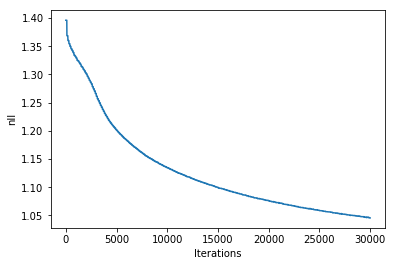

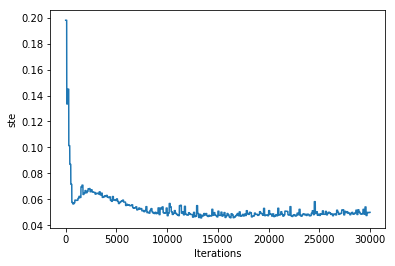

30000 179680000 1.126557 1.064096 0.051712 1.106164 1.045166 0.050159
31000 179680000 1.135074 1.057797 0.066118 1.103321 1.043067 0.049488
32000 179680000 1.104813 1.046270 0.047477 1.100907 1.041074 0.049103
33000 179680000 1.116915 1.053448 0.052551 1.099075 1.039075 0.049268
34000 179680000 1.088218 1.027163 0.050184 1.097970 1.037006 0.050262
35000 179680000 1.076404 1.021828 0.043758 1.095776 1.035067 0.050066
36000 179680000 1.113854 1.054133 0.048704 1.092027 1.032736 0.048563
37000 179680000 1.112205 1.061193 0.040276 1.093190 1.031133 0.051408
38000 179680000 1.125620 1.066900 0.048524 1.099837 1.029243 0.060042
39000 179680000 1.104958 1.045318 0.048889 1.090246 1.027715 0.051861


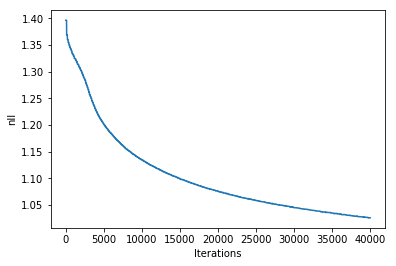

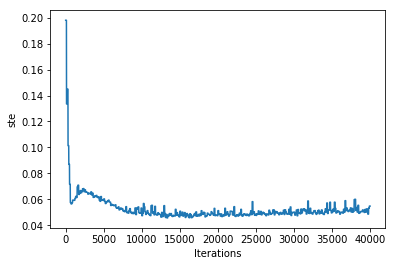

40000 179680000 1.051625 0.994502 0.046371 1.088571 1.025964 0.052061
41000 179680000 1.098014 1.014910 0.072389 1.092536 1.023978 0.057774
42000 179680000 1.067520 1.015373 0.041441 1.084292 1.022626 0.051042
43000 179680000 1.049506 0.991692 0.047346 1.082414 1.021111 0.050753
44000 179680000 1.077814 1.016587 0.050648 1.082485 1.019511 0.052250
45000 179680000 1.084532 1.026857 0.047424 1.080103 1.018583 0.050873
46000 179680000 1.069698 1.010302 0.048702 1.078223 1.016746 0.050970
47000 179680000 1.068361 1.012626 0.045065 1.076703 1.015245 0.050871
48000 179680000 1.023952 0.961802 0.051285 1.078257 1.014171 0.053475
49000 179680000 1.085582 1.014532 0.060907 1.073983 1.012873 0.050611


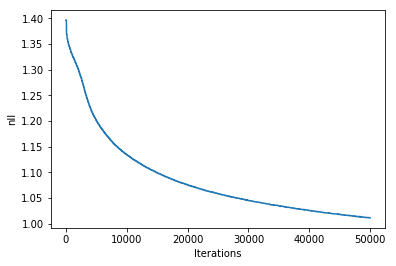

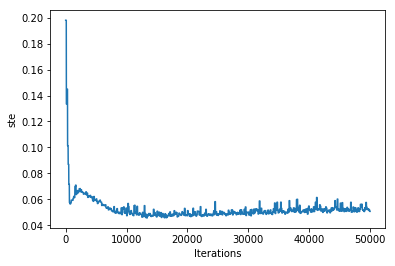

50000 179680000 1.076645 1.000177 0.065518 1.073659 1.011758 0.051385
51000 179680000 1.092416 1.032603 0.049425 1.075858 1.010507 0.054729
52000 179680000 1.041202 0.978495 0.052619 1.073639 1.009530 0.053500
53000 179680000 1.031143 0.968943 0.051718 1.075632 1.007468 0.057656
54000 179680000 1.066521 0.994316 0.061950 1.072602 1.006775 0.055324
55000 179680000 1.104667 1.042241 0.051737 1.066500 1.004667 0.051326
56000 179680000 1.093229 1.021120 0.061708 1.070403 1.004389 0.055423
57000 179680000 1.081607 1.013891 0.056891 1.071271 1.003262 0.057523
58000 179680000 1.079109 1.021172 0.047571 1.071889 1.002685 0.058613
59000 179680000 1.066712 1.009229 0.046893 1.073403 1.000957 0.061771


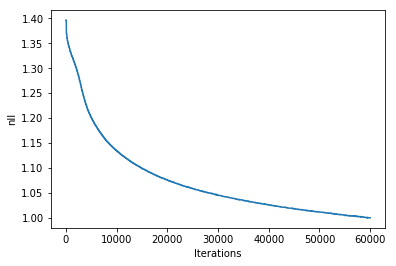

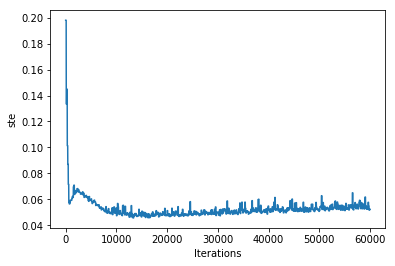

60000 179680000 1.071733 1.001384 0.059983 1.069528 1.000179 0.058877
61000 179680000 1.044755 0.989847 0.044299 1.065611 0.999288 0.055696
62000 179680000 1.045896 0.974835 0.060013 1.069593 0.998228 0.060697
63000 179680000 1.033867 0.959227 0.064410 1.060918 0.996756 0.053600
64000 179680000 1.062177 0.987356 0.064018 1.060682 0.995951 0.054093
65000 179680000 1.058991 0.999804 0.048673 1.058183 0.995039 0.052570
66000 179680000 1.047574 0.981823 0.055112 1.057528 0.993521 0.053426
67000 179680000 1.067459 1.009999 0.046975 1.065774 0.993299 0.061833
68000 179680000 1.107742 1.038483 0.057932 1.058314 0.991855 0.055839
69000 179680000 1.058550 0.975714 0.072716 1.055678 0.990899 0.054249


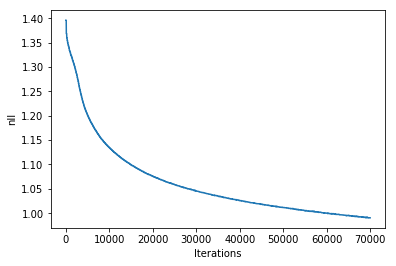

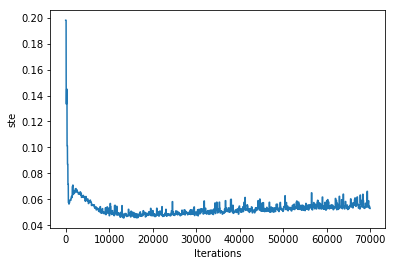

70000 179680000 1.037023 0.978561 0.048065 1.054215 0.990342 0.053278
71000 179680000 1.027563 0.973757 0.043028 1.052691 0.989290 0.052857
72000 179680000 1.044612 0.990862 0.042797 1.052801 0.988886 0.053299
73000 179680000 1.049656 0.984446 0.054818 1.052958 0.987997 0.054471
74000 179680000 1.096468 1.025865 0.060045 1.053348 0.987112 0.055749
75000 179680000 1.033992 0.962954 0.060432 1.054792 0.986314 0.057884
76000 179680000 1.055140 0.991559 0.052406 1.054882 0.986161 0.058080
77000 179680000 1.089107 1.012624 0.066023 1.049392 0.984824 0.054106
78000 179680000 1.109907 1.042249 0.057286 1.052214 0.984251 0.057502
79000 179680000 1.035940 0.975762 0.049339 1.048660 0.983064 0.055050


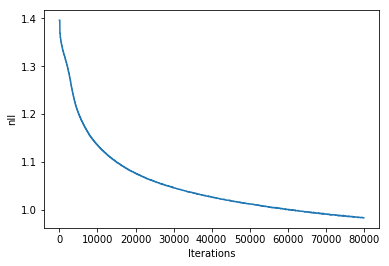

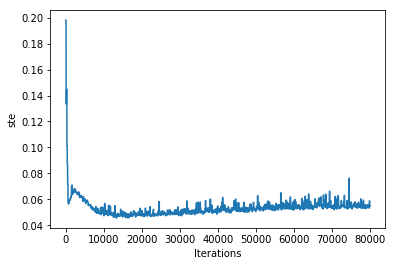

80000 179680000 1.058807 0.994629 0.053837 1.051734 0.982829 0.058429
81000 179680000 1.062260 1.001295 0.050647 1.047236 0.981964 0.054705
82000 179680000 1.017461 0.956759 0.049957 1.053370 0.981181 0.061745
83000 179680000 1.087877 1.023841 0.053540 1.044642 0.980502 0.053629
84000 179680000 1.056630 0.990676 0.055658 1.046642 0.979891 0.056227
85000 179680000 1.032143 0.967427 0.054211 1.058508 0.979639 0.068159
86000 179680000 1.021304 0.955659 0.054781 1.044099 0.978652 0.054899
87000 179680000 1.049411 0.984835 0.054193 1.045785 0.978565 0.056740
88000 179680000 1.089087 1.015378 0.063125 1.042072 0.977189 0.054392
89000 179680000 1.042166 0.975757 0.056186 1.041251 0.976308 0.054446


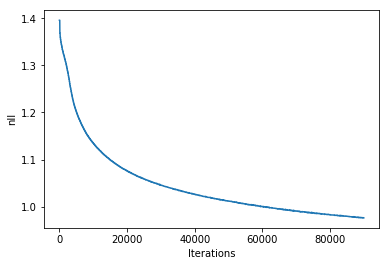

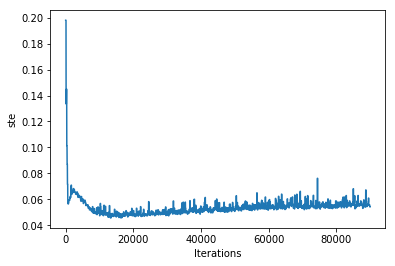

90000 179680000 1.089173 1.026849 0.051788 1.042517 0.976417 0.055635
91000 179680000 1.062039 0.997745 0.053568 1.039955 0.975154 0.054320
92000 179680000 1.024773 0.950475 0.063657 1.041835 0.974651 0.056760
93000 179680000 1.011415 0.942007 0.058781 1.043057 0.974563 0.057954
94000 179680000 1.052162 0.975785 0.066300 1.049426 0.974033 0.065052
95000 179680000 1.024816 0.961015 0.053436 1.041702 0.972907 0.058306
96000 179680000 1.065711 0.992840 0.062511 1.039069 0.973127 0.055496
97000 179680000 1.045712 0.977824 0.057453 1.045586 0.972679 0.062543
98000 179680000 1.027740 0.969720 0.048208 1.037114 0.971109 0.055612
99000 179680000 1.037222 0.960366 0.066399 1.045580 0.971160 0.063894


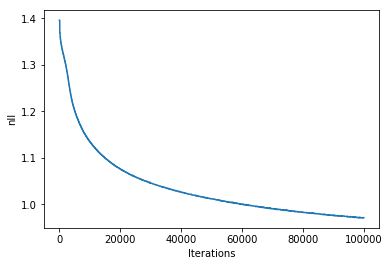

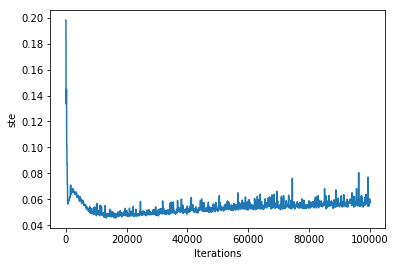

100000 179680000 0.985795 0.915361 0.060193 1.038702 0.971008 0.057346
101000 179680000 1.061693 0.990619 0.060309 1.037685 0.970418 0.056922
102000 179680000 1.082606 1.000189 0.071894 1.043300 0.969664 0.063349
103000 179680000 1.000695 0.939063 0.051368 1.035611 0.968733 0.056543
104000 179680000 1.056652 0.988025 0.058319 1.034886 0.969104 0.055502
105000 179680000 0.997769 0.940326 0.047210 1.039769 0.968218 0.061116
106000 179680000 1.045133 0.976590 0.057934 1.033765 0.968267 0.055182
107000 179680000 1.039255 0.976216 0.052695 1.033069 0.967276 0.055523
108000 179680000 1.062063 1.002289 0.049817 1.033272 0.967439 0.055547
109000 179680000 1.039773 0.979986 0.049456 1.031049 0.966996 0.053820


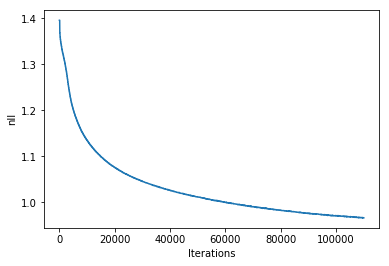

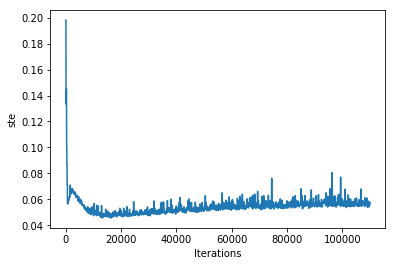

110000 179680000 1.052461 0.983565 0.058846 1.031327 0.966131 0.054952
111000 179680000 1.033889 0.977191 0.046168 1.045086 0.965690 0.069255
112000 179680000 1.040029 0.976998 0.052428 1.030878 0.965437 0.055200
113000 179680000 1.066093 1.004465 0.051191 1.034296 0.964940 0.059172
114000 179680000 1.046731 0.981795 0.054769 1.030051 0.964714 0.055141
115000 179680000 1.008921 0.947136 0.051491 1.028812 0.963689 0.054885
116000 179680000 1.039028 0.965207 0.063322 1.029402 0.964056 0.055137
117000 179680000 1.029821 0.959561 0.060241 1.027945 0.963341 0.054485
118000 179680000 0.987239 0.919575 0.057661 1.028976 0.962884 0.055905
119000 179680000 1.058265 0.990215 0.057798 1.028635 0.962484 0.055999


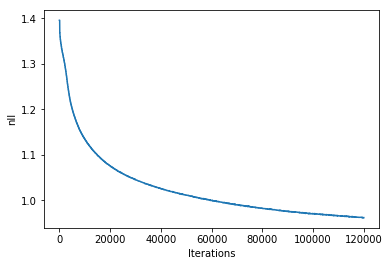

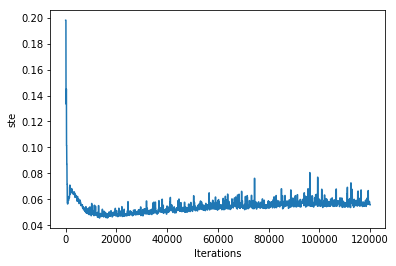

120000 179680000 1.051393 0.991832 0.049416 1.027135 0.962110 0.054844
121000 179680000 1.024107 0.958600 0.055419 1.026572 0.962048 0.054443
122000 179680000 1.000955 0.937214 0.053802 1.034458 0.961311 0.063006
123000 179680000 1.042055 0.980205 0.051923 1.035486 0.961362 0.063901
124000 179680000 1.036053 0.963398 0.062810 1.043516 0.960515 0.072830
125000 179680000 1.038095 0.957934 0.070266 1.027194 0.960391 0.056759
126000 179680000 1.066094 1.001661 0.054431 1.027626 0.959726 0.057845
127000 179680000 0.997067 0.933435 0.053671 1.028255 0.959859 0.058378
128000 179680000 1.096945 1.029792 0.057335 1.028719 0.959159 0.059539
129000 179680000 1.072629 1.004055 0.058168 1.025792 0.959092 0.056649


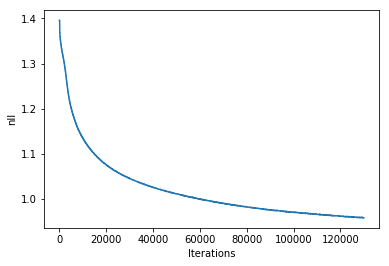

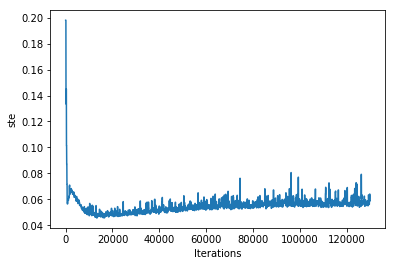

130000 179680000 0.989913 0.920781 0.058803 1.026964 0.958714 0.058270
131000 179680000 1.037273 0.966865 0.060638 1.023479 0.958482 0.055047
132000 179680000 1.060933 0.991510 0.059542 1.025508 0.957799 0.057771
133000 179680000 1.016333 0.957829 0.048087 1.024725 0.957000 0.057823
134000 179680000 1.023221 0.966773 0.046032 1.024343 0.957579 0.056811
135000 179680000 1.020007 0.954936 0.055142 1.023135 0.957717 0.055534
136000 179680000 0.994388 0.931192 0.053065 1.021921 0.956349 0.055662
137000 179680000 1.012780 0.950435 0.052687 1.023581 0.957031 0.056578
138000 179680000 1.017942 0.948984 0.059343 1.028463 0.956438 0.062066
139000 179680000 1.058404 0.993143 0.055400 1.021813 0.955919 0.056039


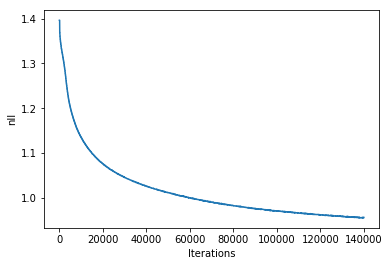

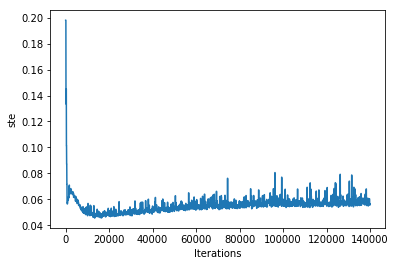

140000 179680000 1.014090 0.950898 0.053444 1.022143 0.955632 0.056738
141000 179680000 1.005382 0.938567 0.057602 1.025518 0.954982 0.060730
142000 179680000 1.004034 0.934021 0.060323 1.022665 0.955008 0.057878
143000 179680000 1.053215 0.980198 0.063488 1.023134 0.954653 0.058671
144000 179680000 1.032324 0.973823 0.048757 1.020370 0.954017 0.056587
145000 179680000 1.009501 0.943627 0.056088 1.023297 0.954228 0.059246
146000 179680000 1.007402 0.943264 0.054295 1.019592 0.954293 0.055486
147000 179680000 0.994902 0.939638 0.045409 1.021174 0.953717 0.057712
148000 179680000 1.060135 0.995444 0.054764 1.016855 0.953269 0.053798
149000 179680000 1.080731 1.005942 0.065179 1.019838 0.952448 0.057605


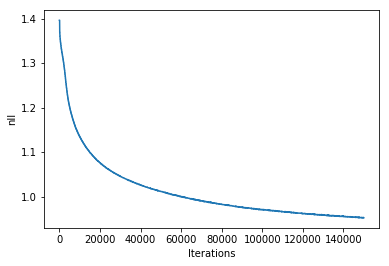

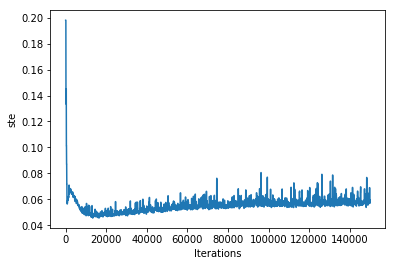

150000 179680000 0.991378 0.925915 0.055593 1.021632 0.952470 0.059493
151000 179680000 0.987909 0.922853 0.055601 1.028013 0.952502 0.065863
152000 179680000 1.022309 0.956267 0.056397 1.025348 0.952270 0.063318
153000 179680000 0.927252 0.864964 0.052706 1.020008 0.952341 0.057945
154000 179680000 0.976577 0.906931 0.059807 1.016213 0.951657 0.054854
155000 179680000 1.035747 0.965765 0.060065 1.018090 0.951592 0.056810
156000 179680000 0.988909 0.926690 0.052682 1.018371 0.951182 0.057555
157000 179680000 1.061341 0.995679 0.055714 1.018090 0.951042 0.057398
158000 179680000 1.029142 0.956928 0.062357 1.018303 0.951071 0.057617
159000 179680000 0.994644 0.933982 0.051263 1.017659 0.950259 0.057800


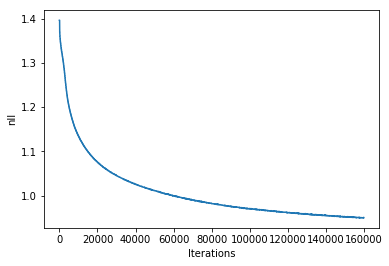

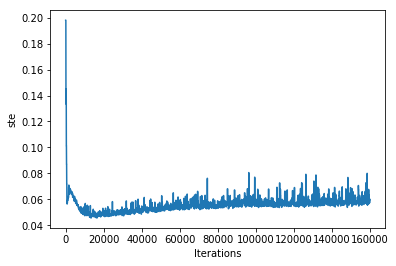

160000 179680000 1.035814 0.975765 0.050309 1.016991 0.950277 0.057089
161000 179680000 1.033544 0.939909 0.084032 1.018493 0.950450 0.058412
162000 179680000 1.016385 0.951603 0.054714 1.030002 0.949685 0.070785
163000 179680000 1.001601 0.939052 0.052678 1.019009 0.949805 0.059646
164000 179680000 1.069391 0.995887 0.063882 1.019277 0.949488 0.060274
165000 179680000 0.976450 0.912473 0.054589 1.020351 0.949752 0.061066
166000 179680000 1.005352 0.928973 0.066764 1.016208 0.949187 0.057386
167000 179680000 1.040632 0.989335 0.041109 1.017532 0.948194 0.059760
168000 179680000 0.990619 0.935159 0.045832 1.014809 0.948208 0.057108
169000 179680000 1.044099 0.982014 0.052155 1.015385 0.947978 0.057890


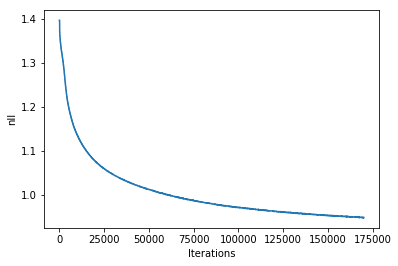

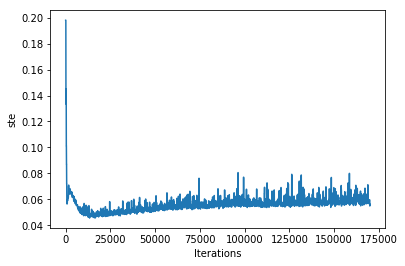

170000 179680000 1.048598 0.983441 0.055948 1.018089 0.948175 0.060365
171000 179680000 1.017620 0.957530 0.050511 1.015800 0.947550 0.058826
172000 179680000 1.025653 0.954344 0.061776 1.015968 0.947113 0.059475
173000 179680000 0.959105 0.899506 0.050283 1.020740 0.947497 0.063839
174000 179680000 0.980550 0.909059 0.062108 1.014001 0.947025 0.057432
175000 179680000 0.959285 0.898600 0.051321 1.014883 0.946261 0.059128
176000 179680000 1.054698 0.991351 0.053497 1.020616 0.947006 0.064085
177000 179680000 1.035359 0.977359 0.048418 1.016626 0.947252 0.059880
178000 179680000 0.990245 0.929662 0.051220 1.011962 0.945896 0.056637
179000 179680000 1.049903 0.989690 0.050821 1.017294 0.945702 0.062092


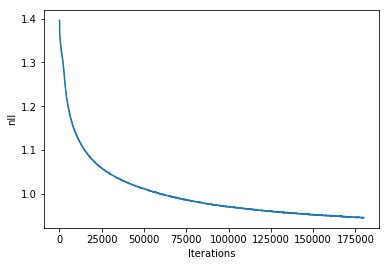

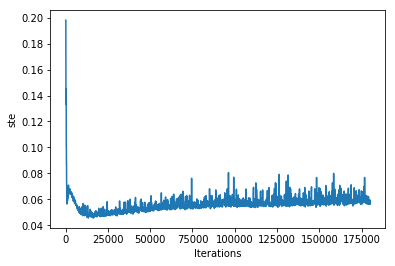

180000 179680000 0.985184 0.910703 0.064900 1.015735 0.945363 0.060991
181000 179680000 0.999985 0.933041 0.057681 1.013600 0.945619 0.058483
182000 179680000 0.974324 0.897979 0.066918 1.012458 0.944955 0.058103
183000 179680000 1.013035 0.950951 0.052750 1.014837 0.945086 0.060362
184000 179680000 1.051086 0.986502 0.055191 1.012272 0.944601 0.058279
185000 179680000 0.970184 0.914926 0.046248 1.010468 0.944482 0.056626
186000 179680000 0.987312 0.909497 0.068621 1.012414 0.944862 0.058238
187000 179680000 0.961810 0.895280 0.057416 1.027609 0.945023 0.073177
188000 179680000 1.017267 0.947128 0.060815 1.012212 0.944676 0.058221
189000 179680000 1.027626 0.969683 0.048555 1.010077 0.943978 0.056805


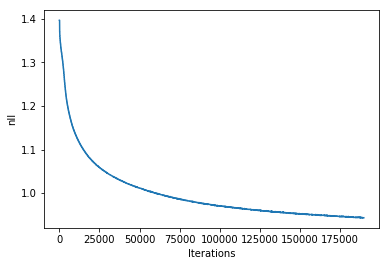

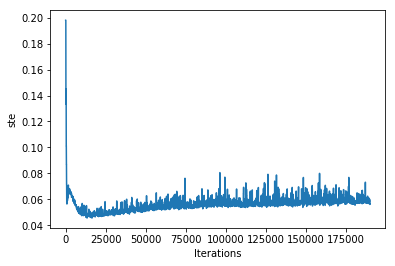

190000 179680000 1.003965 0.928758 0.066399 1.011322 0.943478 0.058608
191000 179680000 0.976346 0.920442 0.046831 1.010973 0.943829 0.057816
192000 179680000 0.980419 0.909659 0.061719 1.011072 0.943093 0.058715
193000 179680000 1.019449 0.952079 0.057935 1.014199 0.942898 0.062015
194000 179680000 1.021096 0.952438 0.059233 1.012314 0.942672 0.060339
195000 179680000 0.983991 0.917874 0.057090 1.011225 0.942332 0.059639
196000 179680000 0.975213 0.901843 0.064024 1.013971 0.942180 0.062544
197000 179680000 1.046236 0.978170 0.058557 1.020143 0.942855 0.068108
198000 179680000 1.032529 0.979558 0.043710 1.010322 0.941896 0.059255
199000 179680000 1.029213 0.964832 0.054963 1.011494 0.941733 0.060554


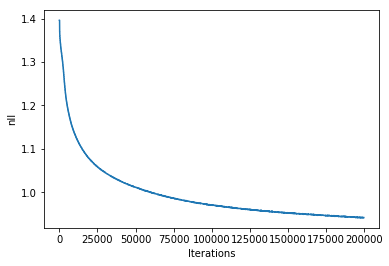

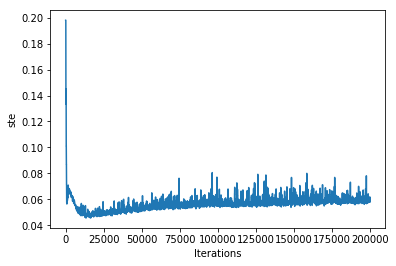

200000 179680000 1.019468 0.953852 0.056647 1.015810 0.942455 0.064126
201000 179680000 1.000798 0.930537 0.061030 1.008405 0.941165 0.058045
202000 179680000 1.059437 0.990370 0.060279 1.007987 0.941267 0.057464
203000 179680000 1.036563 0.966319 0.060662 1.024123 0.941169 0.073647
204000 179680000 0.995855 0.926310 0.060283 1.009942 0.941870 0.058907
205000 179680000 1.014718 0.947813 0.057973 1.009420 0.941503 0.058685
206000 179680000 0.965866 0.905310 0.050965 1.008985 0.940750 0.058960
207000 179680000 0.994702 0.935242 0.050171 1.017549 0.940395 0.068034
208000 179680000 1.014226 0.938518 0.066368 1.008624 0.940157 0.059219
209000 179680000 1.004893 0.946507 0.049175 1.007764 0.940063 0.058548


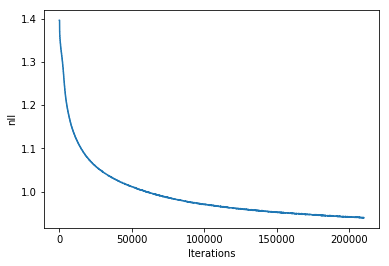

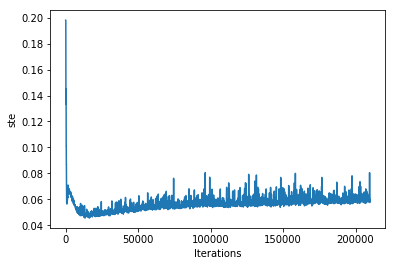

210000 179680000 0.984435 0.908392 0.066948 1.008655 0.939913 0.059503
211000 179680000 0.986907 0.927063 0.050395 1.012518 0.939961 0.063442
212000 179680000 0.985563 0.920746 0.055365 1.007897 0.940062 0.058601
213000 179680000 0.994579 0.929456 0.055803 1.006118 0.939829 0.057058
214000 179680000 1.033738 0.969618 0.054775 1.007553 0.939570 0.058737
215000 179680000 1.039018 0.960793 0.068756 1.008020 0.938875 0.059987
216000 179680000 1.029925 0.956800 0.063507 1.010824 0.939073 0.062533
217000 179680000 0.978795 0.914138 0.055609 1.013547 0.938650 0.065836
218000 179680000 1.046187 0.972349 0.064499 1.019479 0.938547 0.071861
219000 179680000 0.975609 0.906217 0.060503 1.010131 0.938392 0.062537


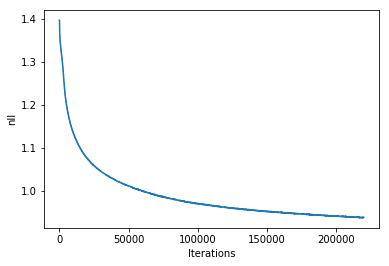

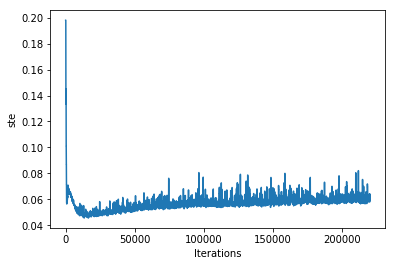

220000 179680000 1.034021 0.962941 0.061760 1.006634 0.938390 0.059101
221000 179680000 0.956246 0.890330 0.056655 1.004200 0.938311 0.056799
222000 179680000 0.937049 0.867576 0.060404 1.009402 0.938251 0.062125
223000 179680000 1.027591 0.962576 0.055614 1.003590 0.937525 0.056963
224000 179680000 1.030434 0.962725 0.058784 1.004987 0.937224 0.058677
225000 179680000 1.027688 0.943587 0.074872 1.006520 0.937588 0.059838
226000 179680000 1.031954 0.965715 0.056908 1.004412 0.936991 0.058373
227000 179680000 1.029366 0.931066 0.089169 1.008808 0.937553 0.062274
228000 179680000 1.003824 0.933681 0.061119 1.009340 0.936498 0.063771
229000 179680000 1.015622 0.948327 0.058449 1.008538 0.936637 0.062808


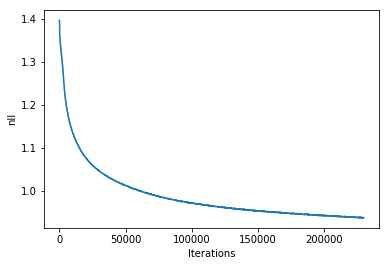

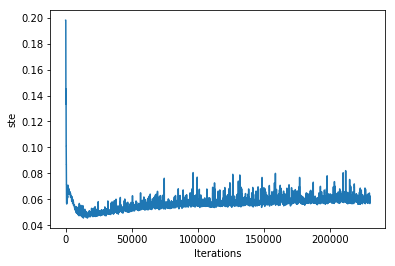

230000 179680000 1.048689 0.977544 0.062035 1.003371 0.935910 0.058432
231000 179680000 0.996149 0.931794 0.055369 1.006095 0.936275 0.060724
232000 179680000 0.964268 0.890410 0.064404 1.002547 0.935515 0.057951
233000 179680000 1.050986 0.982747 0.058794 1.005229 0.936528 0.059691
234000 179680000 0.978049 0.907994 0.061258 1.008862 0.935690 0.064092
235000 179680000 0.982122 0.920870 0.052310 1.002750 0.935606 0.058120
236000 179680000 1.003005 0.947324 0.046414 1.002627 0.935598 0.057995
237000 179680000 1.006489 0.942944 0.054640 1.003270 0.935453 0.058796
238000 179680000 0.966617 0.906887 0.050964 1.002856 0.935313 0.058516
239000 179680000 1.049346 0.977650 0.062839 1.003977 0.935231 0.059768


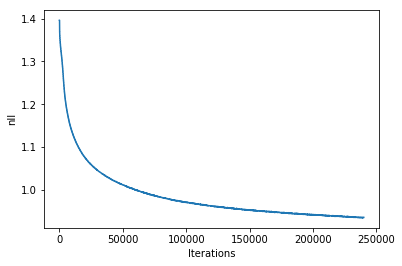

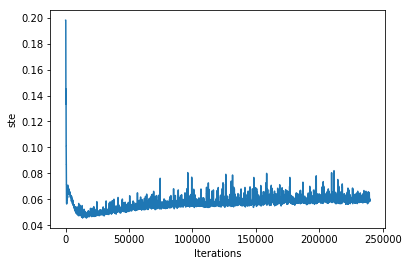

240000 179680000 0.985799 0.923436 0.053537 1.006535 0.935049 0.062542
241000 179680000 0.963476 0.902109 0.052414 1.002301 0.935412 0.058014
242000 179680000 0.979161 0.902593 0.067991 1.001741 0.934196 0.058612
243000 179680000 0.980270 0.923985 0.047307 1.003087 0.934623 0.059521
244000 179680000 0.988857 0.931439 0.048211 1.011055 0.934753 0.067431
245000 179680000 0.988329 0.907854 0.071250 0.999473 0.933914 0.056672
246000 179680000 0.977655 0.913349 0.055660 1.006011 0.934270 0.062771
247000 179680000 1.026262 0.946811 0.070279 1.003429 0.934265 0.060262
248000 179680000 0.998871 0.934097 0.055819 1.002178 0.933603 0.059652
249000 179680000 0.935129 0.863664 0.062325 1.002086 0.933742 0.059460


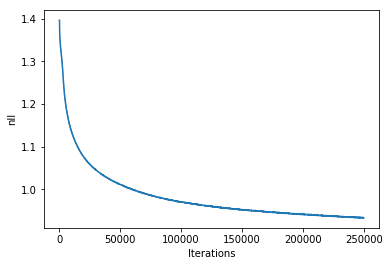

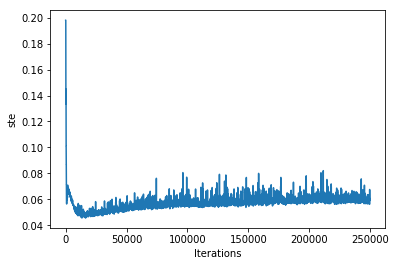

250000 179680000 0.981879 0.919116 0.053855 1.013383 0.933976 0.070595
251000 179680000 1.042011 0.973698 0.059500 1.001392 0.933537 0.058958
252000 179680000 0.988643 0.928925 0.050767 1.007026 0.934081 0.064003
253000 179680000 0.955725 0.890821 0.056005 1.001448 0.933538 0.059034
254000 179680000 1.020414 0.960050 0.051584 1.004473 0.933631 0.061965
255000 179680000 0.996869 0.934202 0.053882 1.001560 0.932752 0.059878
256000 179680000 0.983911 0.920517 0.054645 1.000655 0.933084 0.058752
257000 179680000 0.942807 0.870575 0.063560 1.013923 0.933574 0.071427
258000 179680000 0.970453 0.911893 0.049762 1.001639 0.932826 0.060011
259000 179680000 1.010437 0.945586 0.056274 1.000158 0.932153 0.059198


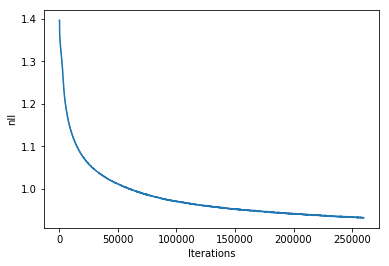

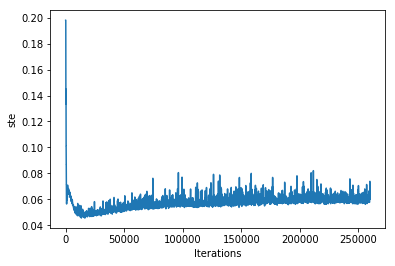

260000 179680000 0.973889 0.903713 0.061374 1.002447 0.932715 0.060924
261000 179680000 0.979072 0.926107 0.043666 0.998245 0.931961 0.057461
262000 179680000 0.939476 0.874389 0.056459 1.002112 0.932555 0.060718
263000 179680000 0.961649 0.899759 0.053070 1.001671 0.932385 0.060515
264000 179680000 0.987022 0.907463 0.070887 0.998420 0.932251 0.057406


KeyboardInterrupt: 

In [67]:
while len(full_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size)
  
  t = len(full_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, step=True, t=t)
  if val_log is None or len(full_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, step=False, t=t)
  
  if len(full_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f %f %f %f %f' % (
        t, n_iters, train_log['loss'],
        train_log['nll'], train_log['ste'], val_log['loss'],
        val_log['nll'], val_log['ste'])
      )
  
  for k, v in train_log.items():
    full_train_logs['%s_evals' % k].append(v)
  for k, v in val_log.items():
    full_train_logs['%s%s_evals' % ('val_' if k in ['loss', 'nll', 'ste'] else '', k)].append(v)
  if len(full_train_logs['loss_evals']) % 10000 == 0:
    for k in ['val_nll_evals', 'val_ste_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(full_train_logs[k])
      plt.show()

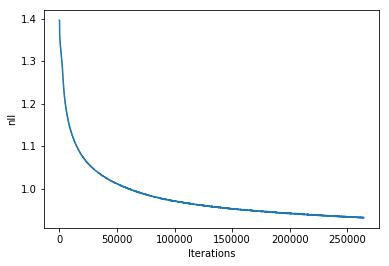

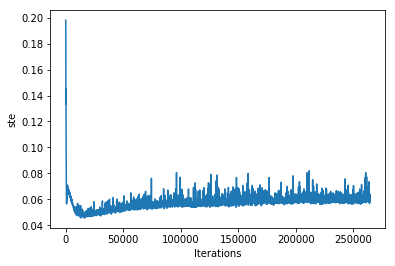

In [68]:
for k in ['val_nll_evals', 'val_ste_evals']:
  plt.xlabel('Iterations')
  plt.ylabel(k.split('_')[1])
  plt.plot(full_train_logs[k])
  plt.show()

In [1]:
with open(os.path.join(data_dir, 'qt_results.pkl'), 'wb') as f:
  pickle.dump(full_train_logs, f)

NameError: name 'os' is not defined

In [60]:
train_constraint_example_idxes = None
val_constraint_batch = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
n_iters_since_prev_constraint_sample = 0

tf.global_variables_initializer().run(session=sess)

n_iters = iterations * demo_obs.shape[1] // batch_size

trans_train_logs = {
  'loss_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
  'int_dyn_err_evals': []
}
val_log = None

### NN learns dynamics real fast, no need for IDL

In [66]:
while len(trans_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size)
  
  t = len(trans_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, trans_only=True, step=True, t=t)
  if val_log is None or len(trans_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, trans_only=True, step=False, t=t)
  
  if len(trans_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f' % (
        t, n_iters, train_log['loss'], val_log['loss'],)
      )

  trans_train_logs['loss_evals'].append(train_log['loss'])
  trans_train_logs['val_loss_evals'].append(val_log['loss'])
  if len(trans_train_logs['loss_evals']) % 10000 == 0:
    for k in ['loss_evals', 'val_loss_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(trans_train_logs[k])
      plt.show()

0 179680000 0.135783 0.134574
1000 179680000 0.000017 0.000019
2000 179680000 0.000006 0.000005
3000 179680000 0.000002 0.000001
4000 179680000 0.000000 0.000001
5000 179680000 0.000000 0.000000


KeyboardInterrupt: 

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.axhline(y=np.mean(ideal_rew), linestyle='--', color='teal', label='Optimal')
plt.axhline(y=np.mean(unassisted_rew), linestyle=':', color='gray', label='Unassisted')
plt.plot(train_logs['assisted_rew_evals'], color='orange', label='Assisted')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('L2 Error')
plt.plot(train_logs['int_dyn_err_evals'], color='orange')
plt.ylim([-0.05, None])
plt.show()

repeat with ten different random seeds

In [ ]:
master_train_logs = []

In [ ]:
for _ in range(10):
  train_constraint_example_idxes = None
  val_constraint_batch = None
  constraint_obs_t = None
  constraint_act_t = None
  constraint_act_t_feats = None
  n_iters_since_prev_constraint_sample = 0
  tf.global_variables_initializer().run(session=sess)
  
  n_iters = 20000
  train_logs = {
    'loss_evals': [],
    'nll_evals': [],
    'ste_evals': [],
    'val_loss_evals': [],
    'val_nll_evals': [],
    'val_ste_evals': [],
    'assisted_rew_evals': [],
    'assisted_succ_evals': [],
    'assisted_crash_evals': [],
    'int_dyn_err_evals'
  }
  
  val_log = None
  while len(train_logs['loss_evals']) < n_iters:
    demo_batch = sample_batch(batch_size)
    constraint_batch = sample_constraint_batch(constraint_batch_size)

    t = len(train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraint_batch, step=True, t=t)
    if val_log is None or t % val_update_freq == 0:
      val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, step=False, t=t)

    if t % 1000 == 0:
      print('%d %d %f %f %f %f %f %f %f' % (
        t, n_iters, train_log['loss'],
        train_log['nll'], train_log['ste'], val_log['loss'],
        val_log['nll'], val_log['ste'], val_log['int_dyn_err'])
      )

    for k, v in train_log.items():
      train_logs['%s_evals' % k].append(v)
    for k, v in val_log.items():
      train_logs['%s%s_evals' % ('val_' if k in ['loss', 'nll', 'ste'] else '', k)].append(v)
      
  master_train_logs.append(train_logs)

In [ ]:
with open(os.path.join(data_dir, 'master_train_logs.pkl'), 'wb') as f:
  pickle.dump(master_train_logs, f, pickle.HIGHEST_PROTOCOL)

viz trajectories

In [ ]:
def plot_trajectories(
  rollouts, goal, title, file_name=None):
  plt.title(title)

  for rollout in rollouts:
    trajectory = [x[0] for x in rollout] + [rollout[-1][3]]
    x, y, vx, vy = list(zip(*trajectory))
    if is_succ(rollout):
      cmap = mpl.cm.YlGn
    elif is_crash(rollout):
      cmap = mpl.cm.YlOrRd
    else:
      cmap = mpl.cm.gray
    plt.scatter(x, y, c=range(len(x)), cmap=cmap, alpha=0.75, linewidth=0)
    plt.scatter(
      [goal[0]], [goal[1]], marker='*', color='yellow', 
      edgecolor='black', linewidth=1, s=300, alpha=0.5)
    
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  if file_name is not None:
    plt.savefig(os.path.join(data_dir, file_name), bbox_inches='tight')
  plt.show()

In [ ]:
n_viz_rollouts = 100
center_goal = np.array([0.5, 0.5])

In [ ]:
test_aristotle_pilot_policy, assisted_env = make_assisted_env(goal=center_goal)
assisted_rollouts = [run_ep(
  test_aristotle_pilot_policy, assisted_env, render=False) for _ in range(n_viz_rollouts)]

In [ ]:
test_aristotle_pilot_policy, unassisted_env = make_env_without_dyn_transfer(
  using_inertia=True, goal=center_goal)
unassisted_rollouts = [run_ep(
  test_aristotle_pilot_policy, unassisted_env, render=False) for _ in range(n_viz_rollouts)]

In [ ]:
unassisted_rollouts_sample = random.sample(unassisted_rollouts, 10)

In [ ]:
mpl.rcParams.update({'font.size': 20})

In [ ]:
plot_trajectories(
  unassisted_rollouts_sample, center_goal, 'Unassisted', 'unassisted-traj.pdf')

In [ ]:
assisted_rollouts_sample = random.sample(assisted_rollouts, 20)

In [ ]:
plot_trajectories(assisted_rollouts_sample, center_goal, 'Assisted', 'assisted-traj.pdf')

In [ ]:
run_ep(test_aristotle_pilot_policy, assisted_env, render=True)

In [ ]:
assisted_env.close()

viz master logs

In [ ]:
with open(os.path.join(data_dir, 'master_train_logs.pkl'), 'rb') as f:
  master_train_logs = pickle.load(f)

In [ ]:
def err_vs_iter_of_logs(master_train_logs):
  n_reps = len(master_train_logs)
  max_iter = max(len(
    train_logs['int_dyn_err_evals']) for train_logs in master_train_logs)
  R = np.zeros((n_reps, max_iter))
  R[:, :] = np.nan
  for i, train_logs in enumerate(master_train_logs):
    errs = train_logs['int_dyn_err_evals']
    R[i, :len(errs)] = errs
  return R

In [ ]:
smooth_win = 100
def moving_avg(d, n=smooth_win):
  s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
  return (s[n:] - s[:-n]) / n

In [ ]:
traj_col_means = lambda x: np.nanmean(x, axis=0)
traj_col_stderrs = lambda x: np.nanstd(x, axis=0) / np.sqrt(
  np.count_nonzero(~np.isnan(x), axis=0))
r_mins = lambda x: traj_col_means(x) - traj_col_stderrs(x)
r_maxs = lambda x: traj_col_means(x) + traj_col_stderrs(x)

In [ ]:
R = err_vs_iter_of_logs(master_train_logs)

In [ ]:
def plot_fill(R, color, label):
  x = range(R.shape[1] - (smooth_win - 1))
  y1 = moving_avg(r_mins(R), n=smooth_win)
  y2 = moving_avg(r_maxs(R), n=smooth_win)
  plt.fill_between(
    x, y1, y2, where=y2 >= y1, interpolate=True, facecolor=color, alpha=0.5)
  plt.plot(moving_avg(traj_col_means(R), n=smooth_win), color=color, label=label)

In [ ]:
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Internal Dynamics L2 Error')
plt.title('2D Continuous-State Navigation')

plot_fill(R, 'orange', 'Our Method')

plt.axhline(y=0.25, linestyle='--', color='gray', label='Random')

plt.ylim([-0.05, None])
plt.xlim([0, 10000])
plt.legend(loc='best')
plt.savefig(os.path.join(data_dir, 'err-vs-iter.pdf'), bbox_inches='tight')
plt.show()